In [1]:
import numpy as np
%matplotlib inline

def points_order_to_binary_state(points_order):
    """
    Transforms the order of points from the standard representation: [0, 1, 2],
    to the binary one: [1,0,0,0,1,0,0,0,1]
    """
    number_of_points = len(points_order)
    binary_state = np.zeros((len(points_order))**2)
    for j in range(len(points_order)):
        p = points_order[j]
        binary_state[(number_of_points) * (j) + (p)] = 1
    return binary_state

def binary_state_to_points_order(binary_state):
    """
    Transforms the the order of points from the binary representation: [1,0,0,0,1,0,0,0,1],
    to the binary one: [0, 1, 2]
    """
    #note does not produce unique paths
    points_order = []
    number_of_points = int(np.sqrt(len(binary_state)))
    for p in range(number_of_points):
        for j in range(number_of_points):
            if binary_state[(number_of_points) * p + j] == 1:
                points_order.append(j)
    return points_order

In [2]:
def get_distance_matrix(cities):
    number_of_cities = len(cities)
    matrix = np.zeros((number_of_cities, number_of_cities))
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            matrix[i][j] = distance_between_points(cities[i], cities[j])
            matrix[j][i] = matrix[i][j]
    return matrix

def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)

#creating an array of cities using their coordinates
cities = np.array([[0, 4],[0, 0],[3, 0]]) #3 cities
#cities = np.array([[0,0], [0,1]]) #2 cities
distance_matrix = get_distance_matrix(cities) #calculates distances between cities and populates an array with them
number_of_cities = len(cities)

In [3]:
import cirq
from scipy import linalg

#begins to contruct the cost hamiltonian by factoring in the distance between the cities
def create_cost_ham(qubits, qc_qaoa, gamma):
    number_of_cities = len(cities)
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            for t in range(number_of_cities - 1):
                if distance_matrix[i][j] != 0:
                    weight = distance_matrix[i][j]/2 #?
                    #chooses qubits to apply the rzz gate to. they must represent different cities
                    q1 = t * number_of_cities + i #
                    q2 = (t + 1) * number_of_cities + j #
                    qc_qaoa.append(cirq.ZZPowGate(exponent=gamma*weight / np.pi, global_shift=-0.5).on(qubits[q1], qubits[q2]))
    
    weight = 10*np.max(distance_matrix) #penalty weight

    #penalty for bilocation (being in the 2 cities at the same time)
    number_of_nodes = len(distance_matrix[0])
    for t in range(number_of_nodes):
        range_of_qubits = list(range(t * number_of_nodes, (t + 1) * number_of_nodes))
        #qc_qaoa.append(cirq.DiagonalGate(diag_angles_radians=[x*gamma*weight for x in [0,1,1,0]]).on(*[qubits[i] for i in range_of_qubits])) #application of penalty operator #2 cities
        qc_qaoa.append(cirq.DiagonalGate(diag_angles_radians=[x*gamma*weight for x in [1, 0, 0, 1, 0, 1, 1, 1]]).on(*[qubits[i] for i in range_of_qubits])) #application of penalty operator
        
    #penalty for repetition (visiting a city more than once)
    for i in range(number_of_nodes):
        range_of_qubits = list(range(i, number_of_nodes**2, number_of_nodes))
        #qc_qaoa.append(cirq.DiagonalGate(diag_angles_radians=[x*gamma*weight for x in [0,1,1,0]]).on(*[qubits[i] for i in range_of_qubits])) #application of penalty operator #2 cities
        qc_qaoa.append(cirq.DiagonalGate(diag_angles_radians=[x*gamma*weight for x in [1, 0, 0, 1, 0, 1, 1, 1]]).on(*[qubits[i] for i in range_of_qubits])) #application of penalty operator
    
    return qc_qaoa
#the cost hamiltonian is now complete

#creates the mixing hamiltonian (allows qaoa angle changes to take effect)
def create_mix_ham(qubits, qc_qaoa, beta):
    for i in range(len(qubits)):
        qc_qaoa.append(cirq.rx(rads=beta).on(qubits[i])) #applies rx gate to all qubits, using an angle from qaoa as a parameter
    return qc_qaoa

def create_qaoa_circuit(nqubits, theta):
    qc_qaoa = cirq.Circuit() #initializes the quantum circuit
    qubits = cirq.LineQubit.range(nqubits)
    #splits qaoa angle theta (array of numbers) into beta and gamma for separate uses (in the cost and mixer hamiltonian)
    beta = theta[:int(len(theta)/2)]
    gamma = theta[int(len(theta)/2):]
    nqubits = len(cities)**2
    
    for i in range(nqubits):
        qc_qaoa.append(cirq.H.on(qubits[i])) #applies hadamard gate to all qubits

    #applies cost and mixing hamiltonians to the circuit (as described in the methods)
    for i in range(len(beta)):
        create_cost_ham(qubits, qc_qaoa, gamma[i])
        create_mix_ham(qubits, qc_qaoa, beta[i])

    qc_qaoa.append(cirq.measure(*qubits, key='result'))
    return qc_qaoa

In [4]:
def compute_expectation(counts, distance_matrix):
    avg = 0
    sum_count = 0
    counts_list = []
    for i in range(0, 2**9):
        counts_list.append((list(np.binary_repr(i, width=9)), counts[i]))
    counts_list = [(binary_state_to_points_order([int(i) for i in x[0]]), x[0], x[1]) for x in counts_list]
    for item in counts_list:
        path = item[0]
        bitstring = item[1]
        count = item[2]

        total = 0
        weight = 10*np.max(distance_matrix)

        for i in range(len(path) - 1):
            total += distance_matrix[path[i]][path[i+1]]

        times = [bitstring[i:i + 3] for i in range(0, len(bitstring), 3)]
        locations = [bitstring[i::3] for i in range(len(cities))]
        for time in times:
            if list(time).count('1')!=1:
                total += weight
                break
        for location in locations:
            if list(location).count('1')!=1:
                total += weight
                break

        avg += total * count
        sum_count += count
    return avg/sum_count

def get_expectation(distance_matrix):
    s = cirq.Simulator()
    
    #executes the circuit
    def execute_circ(theta):
        qc = create_qaoa_circuit(len(distance_matrix[0])**2, theta)
        counts = s.run(qc, repetitions=1000).histogram(key='result') #increase repetitions for better accuracy
        
        return compute_expectation(counts, distance_matrix)
    
    return execute_circ

In [19]:
from scipy.optimize import minimize
np.random.seed()
results = []
for p in range(1, 10):
    result = 0
    for _ in range(30):
        expectation = get_expectation(distance_matrix)

    #     p=3 #increase layers for better accuracy
        lb = np.zeros(2*p)
        ub = np.hstack([np.full(p, np.pi), np.full(p, 2*np.pi)])
        #init_point is a random guess for the initial angle parameter of QAOA
        # init_point = np.random.uniform(lb, ub, 2*p)
        init_point = np.zeros(2*p)

        # minimization; COBYLA is the classical method used
        res = minimize(expectation, 
                              init_point, 
                              method='COBYLA', tol=10e-6)
        result += res.fun
    results.append(result/30)

print(results)

[98.65419999999999, 94.83723333333334, 96.3161, 90.06969999999998, 87.7556666666667, 95.2676, 87.20986666666666, 87.69706666666666, 88.06179999999998]


In [24]:
best = res.x
print(best)

[ 1.19385516  1.12321715 -0.24530315 -0.11285878 -0.19438473  0.28846127
 -0.23521383 -0.04262083 -0.3971122  -0.10739937 -0.47255807 -0.12371154
 -0.13897506 -0.19102232 -0.07893034  0.00144354 -0.09203664  0.01028874]


In [25]:
np.random.seed()

#runs circuit on a quantum simulator
s = cirq.Simulator()
qc_res = create_qaoa_circuit(len(distance_matrix[0])**2, best)
#runs the circuit many (shots) times counts how many times each solution is obtained (correct solution should be most frequent)
counts = s.run(qc_res, repetitions=10000).histogram(key='result')

#following few lines convert the solutions to human-readable form and order the solutions by their frequency
counts_list = []
counts_list1 = []
for i in range(0, 2**9):
    counts_list.append((list(np.binary_repr(i, width=9)), counts[i]))
    counts_list1.append((np.binary_repr(i, width=9), counts[i]))
counts_list1.sort(key=lambda x: -x[1])
print(counts_list1[:10])
counts_list = [(binary_state_to_points_order([int(i) for i in x[0]]), x[1]) for x in counts_list]
counts_list.sort(key=lambda x: -x[1])
print(counts_list[:10])

[('100010001', 320), ('100001010', 285), ('010100001', 247), ('010010010', 200), ('001010100', 193), ('000000000', 146), ('001100010', 127), ('010001100', 120), ('001010010', 104), ('100110000', 99)]
[([0, 1, 2], 320), ([0, 2, 1], 285), ([1, 0, 2], 247), ([1, 1, 1], 200), ([2, 1, 0], 193), ([], 146), ([2, 0, 1], 127), ([1, 2, 0], 120), ([2, 1, 1], 104), ([0, 0, 1], 99)]


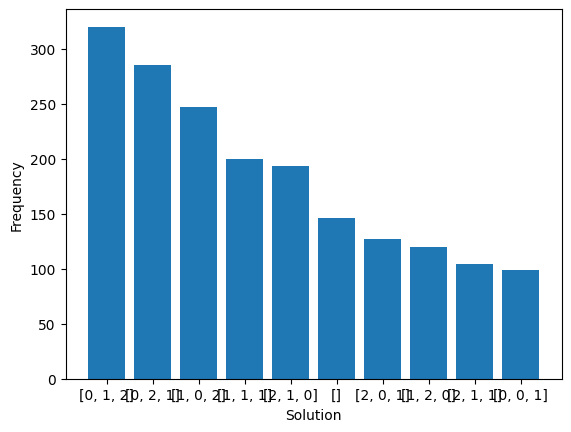

In [26]:
import matplotlib.pyplot as plt
data = [x[1] for x in counts_list[:10]]

plt.bar([str(x[0]) for x in counts_list[:10]],[x[1] for x in counts_list[:10]])
plt.xlabel("Solution")
plt.ylabel("Frequency")
plt.savefig("histogram.png")

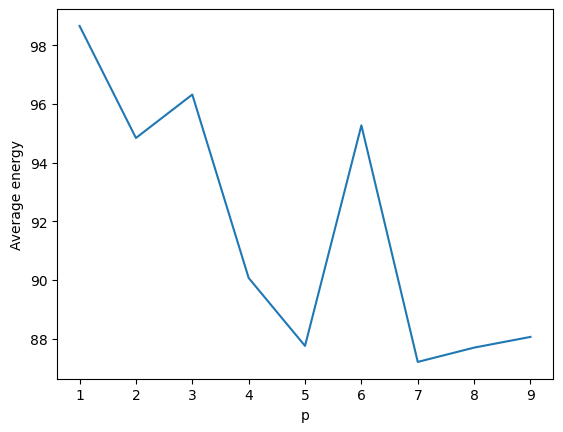

In [29]:
plt.plot([x for x in range(1,10)], [98.65419999999999, 94.83723333333334, 96.3161, 90.06969999999998, 87.7556666666667, 95.2676, 87.20986666666666, 87.69706666666666, 88.06179999999998])
plt.xlabel("p")
plt.ylabel("Average energy")
plt.savefig("p_dependence.png")